In [1]:
# Read dataset
import numpy as np
import pandas as pd

df = pd.read_csv('data/selected_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.iloc[:,:-1]

In [2]:
# Standarize the data
from sklearn.preprocessing import StandardScaler

cols = df.columns.values
df = pd.DataFrame(StandardScaler().fit_transform(df), columns=cols)

In [3]:
# Calculate reconstruction errors
from sklearn.decomposition import PCA
from models.model import ReconstructionErrorModel

model = ReconstructionErrorModel(df, model=PCA(n_components=0.95))
errors = model.predict(df)

In [4]:
# Classify anomalies
threshold = np.std(errors) * 3
df['target'] = 0


for anomaly in np.where(errors > threshold):    
    #df['target'][anomaly] = 1
    df.at[anomaly, 'target'] = 1

df['target'].value_counts()

0    9977
1      37
Name: target, dtype: int64

### Prepare data

In [5]:
from sklearn.model_selection import cross_val_score, train_test_split

seed = 0

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed, stratify=y)

In [6]:
'''
from imblearn.over_sampling import SMOTE, ADASYN

sm = ADASYN(random_state=seed)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=seed, stratify=y_res)

y_res.value_counts()
'''

'\nfrom imblearn.over_sampling import SMOTE, ADASYN\n\nsm = ADASYN(random_state=seed)\nX_res, y_res = sm.fit_resample(X, y)\n\nX_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=seed, stratify=y_res)\n\ny_res.value_counts()\n'

### DecisionTreeClassifier

In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

dt_model = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

f1_score(y_test, y_pred)

0.7272727272727272

/home/xetxezarreta/.conda/envs/AI/lib/python3.8/site-packages/sklearn/externals/six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "


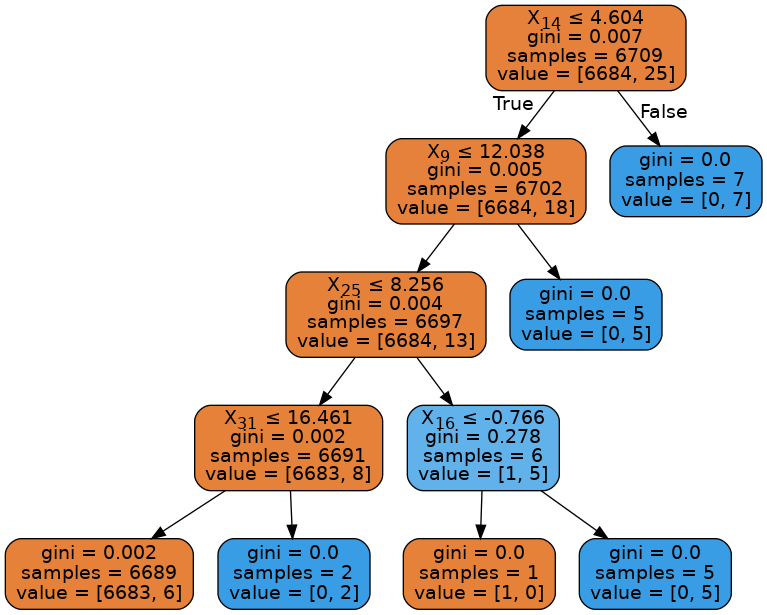

In [8]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Explainability

In [9]:
import shap

explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_train)
#shap.summary_plot(shap_values, X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### RandomForestClassifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf_model = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

f1_score(y_test, y_pred)

0.5882352941176471

### SVC

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

svc_model = SVC(random_state=0).fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

f1_score(y_test, y_pred)

0.2857142857142857